<b>Download data, maak de reconstructies en slaat het databestand op.</b>

In [15]:
"""
Bron van de code: https://github.com/HiSPARC/infopakket/blob/master/notebooks/10_sterrenkaart.md
Merk op dat hier en daar iets is aangepast
"""

from __future__ import division, print_function

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tables
from sapphire import (download_coincidences, ReconstructESDCoincidences, HiSPARCStations)
from sapphire.utils import pbar
from sapphire.transformations.celestial import zenithazimuth_to_equatorial
import os
import time

t0 = time.time()

file_name = 'sciencepark_online_15-18'
DATAFILE = file_name+'.h5'

#STATIONS = [501, 502, 503, 505, 506, 508, 509, 510, 511] # science park
#STATIONS = [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511]  # science park cluster
#STATIONS = [2002,2001,2006,2008,2005,2003,2004]  # Nijmegen
#STATIONS = [305, 304, 301]  # 1,75 km uit elkaar
STATIONS = [501, 502, 508, 510, 511]

"""
Waarschijnlijk moeten stations uit nijmegen gebruikt worden, deze zijn het oudst (data vanaf 2014).
"""

START = datetime(2015, 1, 2)
END = datetime(2018, 3, 1)
N = 5  # Voor richting reconstructions minimum N=3

force_datafile_overwrite = False

if __name__ == '__main__':
    if force_datafile_overwrite:
        try:
            print('Deleting data file')
            os.remove(DATAFILE)
        except:
            print('Could not delete file')
            pass
    #if 'data' not in globals(): # Blijft in globals zitten bij gebruik van notebooks
        # ‘a’: Append; an existing file is opened for reading and writing, and if the file does not exist it is created.
    print('Opening data file')
    data = tables.open_file(DATAFILE, 'a')
    if '/coincidences' not in data:
        print('Downloading coincidences')
        download_coincidences(data, stations=STATIONS, start=START, end=END, n=N)
        t1 = time.time()
        print('Downloading coincidences took: %.2f s' % (t1-t0))
        print("Aantal showers (coincidenties n=%d stations): %d " % (N, len(data.root.coincidences.coincidences)))
    if len(data.root.coincidences.coincidences) == 0:
        print('Aantel showers == 0, exit()')
        exit()
    if '/coincidences/reconstructions' not in data:
        print('Creating reconstructions')
        rec = ReconstructESDCoincidences(data, overwrite=True)
        rec.reconstruct_and_store()
        t2 = time.time()
        print('Creating reconstructions took: %.2f s' % (t2-t1))
        print("Aantal reconstructions (reconstructions n=%d stations): %d " % (N, len(data.root.coincidences.reconstructions)))
    if len(data.root.coincidences.reconstructions.read()) == 0:
        print('Aantel recs == 0, exit()')
        exit()

data.close()
print('----- READY -----')

Opening data file
----- READY -----


<b>Open databestand, transformeert GPS coordinaten naar celestrialcoordinates, slaat de getransformeerde data punten (R.A. en DEC) op als csv. </b>

In [16]:
t3 = time.time()

try:
    data = tables.open_file(DATAFILE, 'r+')
except:
    print('Could not open data file, exit()')
    exit()
    pass

t4 = time.time()
print('Opening data took: %.5f' % (t4-t3))
print('Aantal coincidenties: %s' % len(data.root.coincidences.coincidences))
print("Aantal reconstructions: %d " % (len(data.root.coincidences.reconstructions)))

recs = data.root.coincidences.reconstructions.read()
data.close()
theta = recs['zenith']
recs = recs.compress(~np.isnan(theta))

t5 = time.time()
print('Removing NaNs from recs[theta] took: %.5f' % (t5-t4))

print("Aantal reconstructions : %.2f " % (len(recs)))

lla = HiSPARCStations(STATIONS).get_lla_coordinates()
lat, lon, alt = lla

t6 = time.time()
print('get_lla_coordinates() took: %.5f' % (t6-t5))

events = []
for rec in pbar(recs):
    # omzetten naar 1 functie die matrix rekening doet? 1.5mil punten duurd 3 minuten
    timestamp = rec['ext_timestamp'] / 1.e9
    theta = rec['zenith']
    phi = rec['azimuth']
    r, d = zenithazimuth_to_equatorial(lat, lon, timestamp, theta, phi)  # Zelf maken zodat het sneller gaat?
    events.append((r-np.pi, d))
events = np.array(events)

t7 = time.time()
print('Creating events = np.array(events) took: %.5f' % (t7-t6))

ra = np.degrees(events[:, 0])

dec = np.degrees(events[:, 1])

t8 = time.time()
print('RA & DEC naar degrees omzetten took: %.5f' % (t8-t7))


t9 = time.time()
print('Total runtime: %.2f' % (t9-t8))

np.savetxt("data\\"+file_name+".csv", events, delimiter="\t")

print('-----READY-----')

Opening data took: 0.00097
Aantal coincidenties: 107478
Aantal reconstructions: 107478 
Removing NaNs from recs[theta] took: 0.06417
Aantal reconstructions : 106420.00 


N/A%|                                                           |ETA:  --:--:--

get_lla_coordinates() took: 3.36362


100%|############################################################|Time: 0:00:09


Creating events = np.array(events) took: 9.74560
RA & DEC naar degrees omzetten took: 0.00151
Total runtime: 0.00
-----READY-----


<b>Open csv bestand, defineer de plot functie.</b>

In [17]:
events = np.loadtxt("data\\"+file_name+".csv")
show_events = False

# RA, DEC tuples van het steelpan asterisme in het sterrenbeeld Grote Beer
"""
RA en DEC zijn vindbaar met Aladin. Coordinaten daarvandaan pakken en dan een functie maken voor het omzetten naar graden?
"""
steelpan = np.array([[13.792222, 49.3167], [13.398889, 54.9333], [12.900556, 55.95],
                     [12.257222, 57.0333], [11.896944, 53.7000], [11.030833, 56.3833],
                     [11.062222, 61.7500], [12.257222, 57.0333]])

# Melkweg contouren als lijst van RA, DEC paren.
# `milky_way.npy` heeft *geen* verbinding tussen RA 23h59 en 0h00 en `milky_way_polar.npy` wel.
try:
    mw_contour = np.load('milky_way.npy')
    print('Loaded .npy files')
except:
    mw_contour = []
    print('Failed to load .npy files')

def plot_events_on_mollweide(events, filename=None):
    # Plot events (een lijst van RA, DEC tuples) op een kaart in Mollweide projectie"""

    # Let op: De RA-as is gespiegeld. Alle RA coordinates worden gespiegeld (negatief)
    # geplot.

    events = np.array(events)

    fig = plt.figure(figsize=(15, 15))
    #fig = plt.figure()
    ax = fig.add_subplot(111, projection="mollweide")
    
        # plot milky way contours
    for ra_mw, dec_mw in mw_contour:
        ax.plot(-ra_mw, dec_mw, color='grey')
    
    # let op: De RA as is gespiegeld:
    ax.set_xticklabels(['22', '20', '18', '16', '14', '12', '10', '8,0', '6,0', '4,0', '2,0'], fontsize='large')
    ax.set_yticklabels(['-75', '-60', '-45', '-30', '-15', '0', '15', '30', '45', '60', '75'], fontsize='large')
    ax.grid(True)
    ax.tick_params(axis='x', colors='white')
    ax.xaxis.label.set_color('white')
    ax.xaxis.set_label_coords(.5, .49)
    
        # plot milky way contours
    for ra_mw, dec_mw in mw_contour:
        ax.plot(-ra_mw, dec_mw, color='grey', alpha=.5)

    """
    Plot bron:
    https://python-graph-gallery.com/85-density-plot-with-matplotlib/
    """
    from scipy.stats import kde
    x = -events[:, 0]
    y = events[:, 1]

    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    t10 = time.time()
    
    nbins = 200
    k = kde.gaussian_kde([x, y])
    
    t11 = time.time()
    print('kde.gaussian_kde: %.2f s' % (t11-t10))
    
    xi, yi = np.mgrid[x.min():x.max():nbins * 1j, y.min():y.max():nbins * 1j]
    
    t12 = time.time()
    print('np.mgrid: %.2f s' % (t12-t11))
    
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    t13 = time.time()
    print('np.vstack: %.2f s' % (t13-t12))
    """ 
    Colormaps: https://matplotlib.org/examples/color/colormaps_reference.html
    jet

    """
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.jet, alpha=1)
    
    t14 = time.time()
    print(' plt.pcolormesh: %.2f s' % (t14-t13))
    
    plt.colorbar(shrink=0.5, pad=0.01)
    if show_events:
        ax.scatter(-events[:, 0], events[:, 1], marker='x', alpha=.5, color='grey', label='events')

    # plot steelpan in UMa
    ra_uma = np.radians(steelpan[:, 0] / 24 * 360 - 180.)
    dec_uma = np.radians(steelpan[:, 1])
    ax.plot(-ra_uma, dec_uma, color='white')
    ax.scatter(-ra_uma, dec_uma, color='white', s=10)

    # plot Polaris
    #ax.scatter(0., np.radians(90.), color='white', marker='*')
    #ax.text(np.radians(2.), np.radians(78.), 'Polaris', color='white', fontsize='10')

    # plot Galactic Center (RA 17h45, DEC -29)
    #ax.scatter(-np.radians(17.75 / 24 * 360 - 180.), np.radians(-29), color='white', marker='*')
    #ax.text(-np.radians(17.75 / 24 * 360 - 180. +2.), np.radians(-29 - 6.), 'Galactic Center', color='white', fontsize='10')

    plt.grid(alpha=.3)
    plt.xlabel('Rechte klimming [h]', fontsize='large')
    plt.ylabel('Declinatie [°]', fontsize='large')
    plt.tight_layout()
    #plt.legend()

    if filename:
        plt.savefig(filename, dpi=200)
    plt.show()

print('-----READY-----')

Loaded .npy files
-----READY-----


<b>Maak de plot.</b>

kde.gaussian_kde: 0.00 s
np.mgrid: 0.00 s
np.vstack: 234.36 s
 plt.pcolormesh: 0.01 s


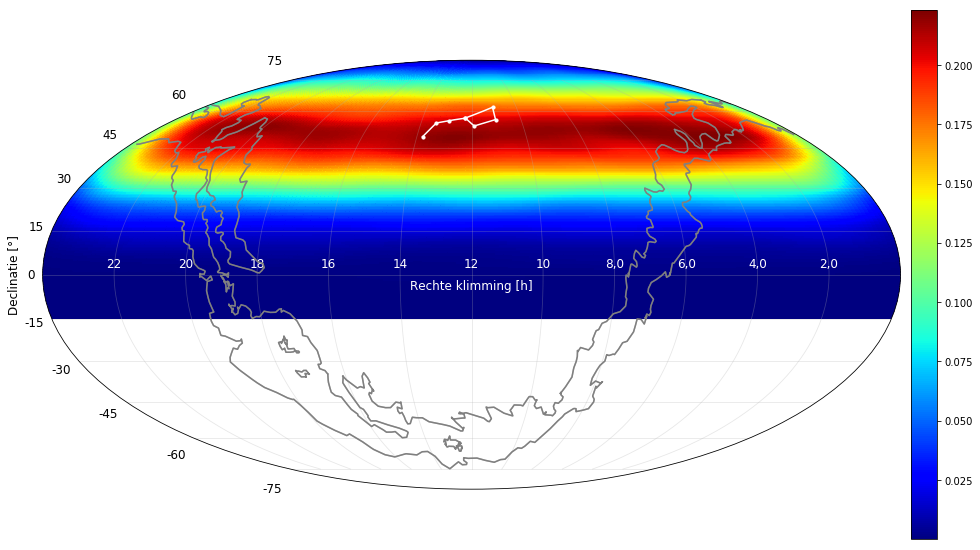

Plotting took: 236.19 s


In [18]:
t15 = time.time()

plot_events_on_mollweide(events, filename='figuren\\noordelijke_hemel_mollweide.png')

t16 = time.time()
print('Plotting took: %.2f s' % (t16-t15))